Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data=pd.read_csv('Restaurant_reviews.csv')

data.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


Data *Preprocessing*

In [3]:
data.info()
data['Time']=pd.to_datetime(data['Time'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [4]:
data.isnull().sum()

Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [5]:
data=data.dropna(subset=['Rating'])
data.reset_index(drop=True, inplace=True)
data['Rating']=data['Rating'].apply(lambda x:'2.5' if x=='Like' else x)
data['Rating']=data['Rating'].astype(float)

#Found out that the ratings were given as strings and it would be easier to comprehend it as numbers
#Also found some ratings were given as 'Like' and changed it to have a moderate rating of 2.5
data.isnull().sum()

<ipython-input-5-837e94458ad7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rating']=data['Rating'].apply(lambda x:'2.5' if x=='Like' else x)
<ipython-input-5-837e94458ad7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Rating']=data['Rating'].astype(float)


Restaurant    0
Reviewer      0
Review        7
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [6]:
imputers = SimpleImputer(strategy='constant', fill_value='Review unavailable')

data[['Review']] = imputers.fit_transform(data[['Review']])

data.isnull().sum()

<ipython-input-6-e75fc74f8bbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Review']] = imputers.fit_transform(data[['Review']])


Restaurant    0
Reviewer      0
Review        0
Rating        0
Metadata      0
Time          0
Pictures      0
dtype: int64

In [7]:
duplicate_rows = data.duplicated()
print(data[duplicate_rows])

Empty DataFrame
Columns: [Restaurant, Reviewer, Review, Rating, Metadata, Time, Pictures]
Index: []


In [8]:
# creating separate dataframe for reviewers and removing the metadata column from the common data table
data_sorted=data.sort_values(by=['Reviewer','Time'],ascending=[True,False])
temp=data_sorted.drop_duplicates(subset=['Reviewer'],keep='first')
temp1=temp['Metadata'].str.split(',',expand=True)

temp1.isnull().sum()
temp1[0].fillna('1',inplace=True)
temp1[1].fillna('0',inplace=True)

#print(temp)
temp['Nos_Reviews']=temp1[0].str.extract('(\d+)').astype(int)
temp['Nos_followers']=temp1[1].str.extract('(\d+)').astype(int)
reviewer_data=temp[['Reviewer','Nos_Reviews','Nos_followers']]
print(reviewer_data.head())

#print(reviewer_data[reviewer_data['Reviewer']=='G. Sushmitha Reddy'])

data=data.drop(columns=['Metadata'])


                         Reviewer  Nos_Reviews  Nos_followers
9663                    #FOODPORN           35           5873
614           #chloesviews // CAH            3              1
2420                         $ign           50             55
4619                     4mybanti            7              4
9945  @FuloriBinaChutneyKaiseBani           86            244


<ipython-input-8-71a7ec53eb4d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Nos_Reviews']=temp1[0].str.extract('(\d+)').astype(int)
<ipython-input-8-71a7ec53eb4d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Nos_followers']=temp1[1].str.extract('(\d+)').astype(int)


In [9]:
#Processing Reviews in an attempt to keep only words which are influential in deciding if it is a positive or negative review
review_modified=[]
stop_words=list(stopwords.words('english'))
stop_words.remove('not')
for i in range(len(data['Review'])):
   review = re.sub('[^a-zA-Z]',' ',data['Review'][i])
   review=review.lower()
   review=review.split()
   ps=PorterStemmer()
   review=[ps.stem(word) for word in review if word not in stop_words]
   review=' '.join(review)
   review_modified.append(review)
data['Review']=review_modified

print(data.head())


        Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  \
0  ambienc good food quit good saturday lunch cos...     5.0   
1  ambienc good pleasant even servic prompt food ...     5.0   
2  must tri great food great ambienc thnx servic ...     5.0   
3  soumen da arun great guy behavior sincereti go...     5.0   
4  food good order kodi drumstick basket mutton b...     5.0   

                 Time  Pictures  
0 2019-05-25 15:54:00         0  
1 2019-05-25 14:20:00         0  
2 2019-05-24 22:54:00         0  
3 2019-05-24 22:11:00         0  
4 2019-05-24 21:37:00         0  


EDA

In [10]:
print("The Most popular Reviewer is :\n")
print(reviewer_data[reviewer_data['Nos_followers']==reviewer_data['Nos_followers'].max()])

The Most popular Reviewer is :

             Reviewer  Nos_Reviews  Nos_followers
3927  Satwinder Singh          186          13410


In [11]:
print("The total no of different restaurants :\n",len(list(data['Restaurant'].unique())))
print("The different restaurants are :")
Restaurants=list(data['Restaurant'].unique())
print(Restaurants)
print("The total no of different reviewers :\n",len(data['Reviewer'].unique()))

#Reviewer who has done more than two reviews for the same restaurant
review_counts = data.groupby(['Restaurant', 'Reviewer']).size().reset_index(name='Review Count')
frequent_reviewers = review_counts[review_counts['Review Count'] > 2]
print("Reviewers who have done more than two reviews for the same restaurant:\n")
print(frequent_reviewers)

The total no of different restaurants :
 100
The different restaurants are :
['Beyond Flavours', 'Paradise', 'Flechazo', 'Shah Ghouse Hotel & Restaurant', 'Over The Moon Brew Company', "The Fisherman's Wharf", 'eat.fit', 'Shah Ghouse Spl Shawarma', 'Hyper Local', 'Cream Stone', "Sardarji's Chaats & More", 'Barbeque Nation', 'Absolute Sizzlers', 'The Lal Street - Bar Exchange', "AB's - Absolute Barbecues", 'KFC', 'NorFest - The Dhaba', 'Hotel Zara Hi-Fi', '10 Downing Street', 'Pakwaan Grand', '13 Dhaba', "Jonathan's Kitchen - Holiday Inn Express & Suites", 'B-Dubs', 'Amul', 'SKYHY', 'Tiki Shack', 'Mustang Terrace Lounge', "3B's - Buddies, Bar & Barbecue", 'Behrouz Biryani', 'Hunger Maggi Point', 'Pot Pourri', 'Pista House', 'Marsala Food Company', 'Club Rogue', 'Mazzo - Marriott Executive Apartments', 'Green Bawarchi Restaurant', 'Banana Leaf Multicuisine Restaurant', 'Kritunga Restaurant', 'The Glass Onion', 'Deli 9 Bistro', 'Frio Bistro', 'Karachi Bakery', 'Karachi Cafe', 'The Foodie 

In [12]:
rest_group=data.groupby('Restaurant')
print("The summary stats per restaurant:\n")
desc=rest_group.agg({'Rating':['mean','min','max','count'],'Pictures': ['sum'],'Review': ['count']}).reset_index()
desc.columns = ['Restaurant', 'Avg Rating', 'Min Rating', 'Max Rating', 'Rating Count', 'Total Pictures', 'Review Count']
print(desc)
#Particular Data Stats
#print(desc[desc['Restaurant']=='10 Downing Street'])

print("The Most preferred Restaurant is : \n",desc[['Restaurant','Avg Rating']][desc['Avg Rating']==desc['Avg Rating'].max()])
print("The Least preferred restaurant is : \n",desc[['Restaurant','Avg Rating']][desc['Avg Rating']==desc['Avg Rating'].min()])

The summary stats per restaurant:

                               Restaurant  Avg Rating  Min Rating  Max Rating  \
0                       10 Downing Street        3.80         1.0         5.0   
1                                13 Dhaba        3.48         1.0         5.0   
2          3B's - Buddies, Bar & Barbecue        4.76         1.0         5.0   
3               AB's - Absolute Barbecues        4.88         2.0         5.0   
4                       Absolute Sizzlers        3.62         1.0         5.0   
..                                    ...         ...         ...         ...   
95             Urban Asia - Kitchen & Bar        3.65         1.0         5.0   
96  Yum Yum Tree - The Arabian Food Court        3.56         1.0         5.0   
97        Zega - Sheraton Hyderabad Hotel        4.45         1.0         5.0   
98               Zing's Northeast Kitchen        3.65         1.0         5.0   
99                                eat.fit        3.20         1.0         

In [13]:
print("Top 5 Restaurants with highest rating :\n")
print(desc[['Restaurant','Avg Rating']].sort_values(by='Avg Rating',ascending=False).head())
print("Lowest 5 Restaurants according to the rating :\n")
print(desc[['Restaurant','Avg Rating']].sort_values(by='Avg Rating').head())

Top 5 Restaurants with highest rating :

                        Restaurant  Avg Rating
3        AB's - Absolute Barbecues        4.88
11                          B-Dubs        4.81
2   3B's - Buddies, Bar & Barbecue        4.76
67                        Paradise        4.70
35                        Flechazo        4.66
Lowest 5 Restaurants according to the rating :

          Restaurant  Avg Rating
41  Hotel Zara Hi-Fi       2.400
10    Asian Meal Box       2.580
66     Pakwaan Grand       2.710
57     Mathura Vilas       2.820
14   Behrouz Biryani       2.825


Plots

Text(0, 0.5, 'Count')

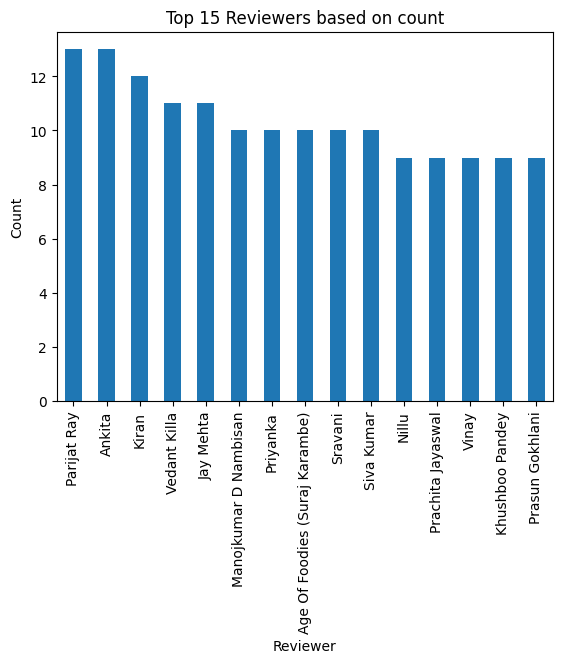

In [14]:
ax=data['Reviewer'].value_counts().head(15).plot(kind='bar',title='Top 15 Reviewers based on count')
ax.set_ylabel('Count')


In [15]:
#Check for normal distribution using CHISQ test
from scipy.stats import norm,chisquare,chi2

num_bins = 9
bins = np.linspace(data['Rating'].min(), data['Rating'].max(), num_bins)
print(bins)

mu, std = norm.fit(data['Rating'])
expected_freq = []
for i in range(num_bins-1):
    prob = norm.cdf(bins[i+1], mu, std) - norm.cdf(bins[i], mu, std)
    expected_freq.append(prob * len(data))

expected_freq = np.array(expected_freq)
print(expected_freq)
observed_freq, _ = np.histogram(data['Rating'], bins=bins)
scale_factor = sum(observed_freq) / sum(expected_freq)
expected_freq = expected_freq * scale_factor
chi2_test,p_val= chisquare(observed_freq, expected_freq)[0:2]

print("p value :",p_val)
print("CHI2 Stat :",chi2_test)
critical_value = chi2.ppf(0.95, num_bins-1)
print("Critical value at 0.05 level of significance:", critical_value)



[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[ 384.2590749   616.61365     884.13663392 1132.77792171 1296.85258161
 1326.6538033  1212.67907194  990.50110481]
p value : 0.0
CHI2 Stat : 13243.773242003177
Critical value at 0.05 level of significance: 15.50731305586545


<Axes: ylabel='Density'>

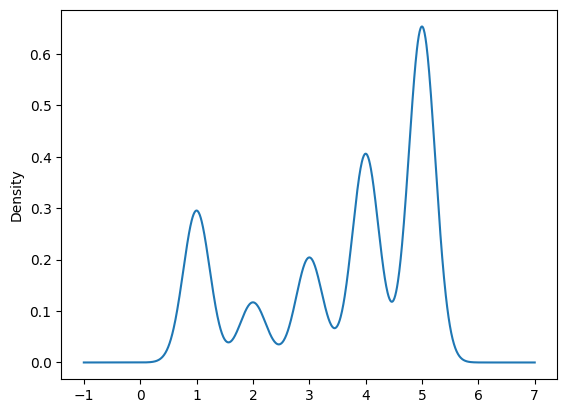

In [16]:
data['Rating'].plot(kind='kde')

4.88
5.0
0    5.0
Name: Rating, dtype: float64


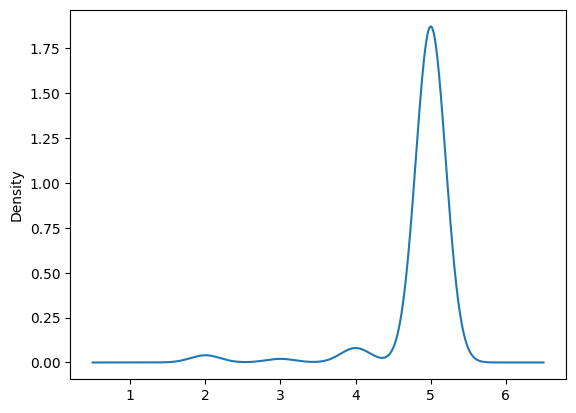

In [17]:
data[data['Restaurant']=='AB\'s - Absolute Barbecues']['Rating'].plot(kind='kde')
print(data[data['Restaurant']=='AB\'s - Absolute Barbecues']['Rating'].mean())
print(data[data['Restaurant']=='AB\'s - Absolute Barbecues']['Rating'].median())
print(data[data['Restaurant']=='AB\'s - Absolute Barbecues']['Rating'].mode())

2.4
1.0
0    1.0
Name: Rating, dtype: float64


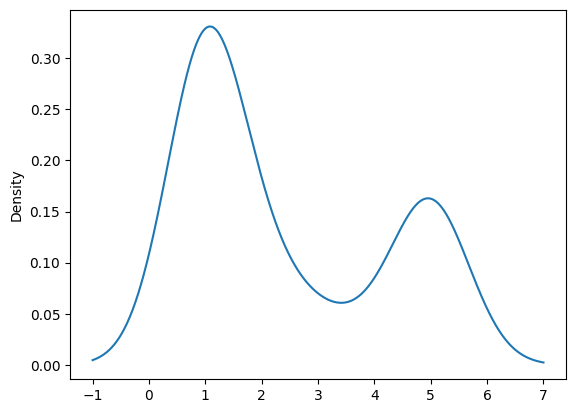

In [18]:
data[data['Restaurant']=='Hotel Zara Hi-Fi']['Rating'].plot(kind='kde')
print(data[data['Restaurant']=='Hotel Zara Hi-Fi']['Rating'].mean())
print(data[data['Restaurant']=='Hotel Zara Hi-Fi']['Rating'].median())
print(data[data['Restaurant']=='Hotel Zara Hi-Fi']['Rating'].mode())

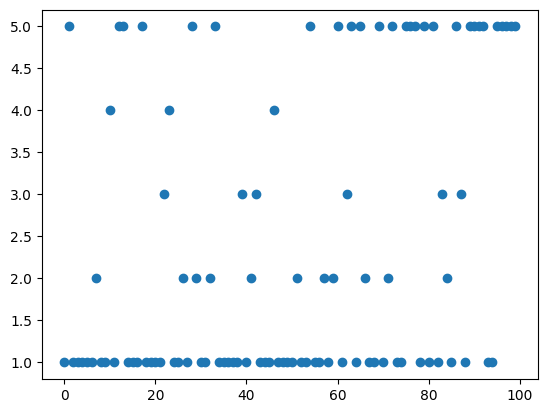

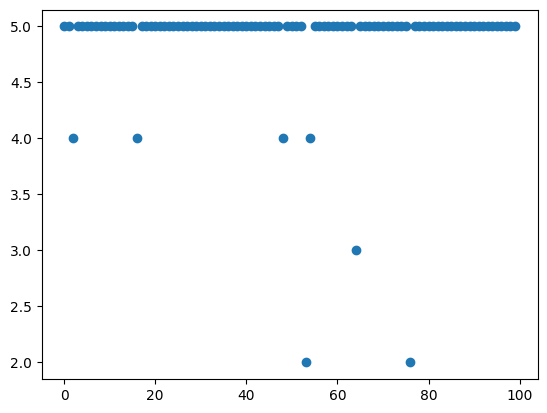

In [19]:
grp=rest_group.get_group('Hotel Zara Hi-Fi')
plt.scatter(np.arange(len(grp['Rating'])),grp['Rating'])
plt.show()

grp=rest_group.get_group('AB\'s - Absolute Barbecues')
plt.scatter(np.arange(len(grp['Rating'])),grp['Rating'])

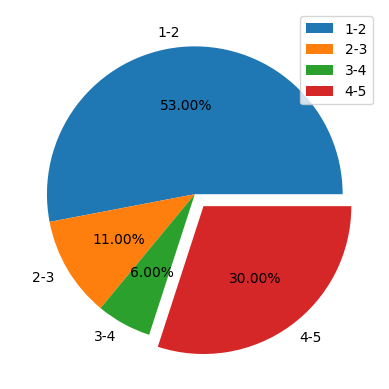

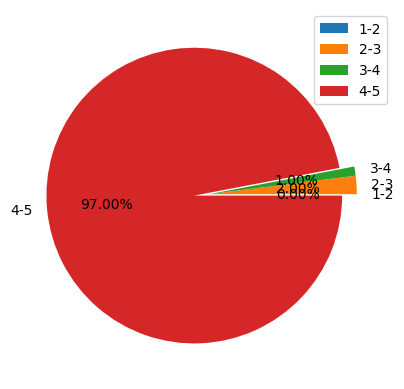

In [20]:
temp=data[data['Restaurant']=='Hotel Zara Hi-Fi']
Categories=['1-2','2-3','3-4','4-5']
Categories_counts=[0,0,0,0]
for i in range(len(temp)):
    if temp.iloc[i].Rating>=1 and temp.iloc[i].Rating<2:
        Categories_counts[0]+=1
    elif temp.iloc[i].Rating>=2 and temp.iloc[i].Rating<3:
        Categories_counts[1]+=1
    elif temp.iloc[i].Rating>=3 and temp.iloc[i].Rating<4:
        Categories_counts[2]+=1
    else:
        Categories_counts[3]+=1
plt.pie(Categories_counts,labels=Categories,explode=[0,0,0,0.1],autopct="%1.2f%%")
plt.legend()
plt.show()

temp=data[data['Restaurant']=='AB\'s - Absolute Barbecues']
Categories=['1-2','2-3','3-4','4-5']
Categories_counts=[0,0,0,0]
for i in range(len(temp)):
    if temp.iloc[i].Rating>=1 and temp.iloc[i].Rating<2:
        Categories_counts[0]+=1
    elif temp.iloc[i].Rating>=2 and temp.iloc[i].Rating<3:
        Categories_counts[1]+=1
    elif temp.iloc[i].Rating>=3 and temp.iloc[i].Rating<4:
        Categories_counts[2]+=1
    else:
        Categories_counts[3]+=1
plt.pie(Categories_counts,labels=Categories,explode=[0,0,0,0.1],autopct="%1.2f%%")
plt.legend()
plt.show()

Regression Analysis

In [21]:
data.corr(numeric_only=True)

,Rating,Pictures
Rating,1.000000,0.082645
Pictures,0.082645,1.000000


Sentiment analysis

In [22]:
reference_data=pd.read_csv('Restaurant_Reviews.tsv',delimiter='\t',quoting=3)
reference_data.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [23]:
reference_data['Liked'].value_counts()

Liked
1    500
0    500
Name: count, dtype: int64

In [24]:
review_modified=[]
stop_words=list(stopwords.words('english'))
stop_words.remove('not')
for i in range(len(reference_data['Review'])):
   review = re.sub('[^a-zA-Z]',' ',reference_data['Review'][i])
   review=review.lower()
   review=review.split()
   ps=PorterStemmer()
   review=[ps.stem(word) for word in review if word not in stop_words]
   review=' '.join(review)
   review_modified.append(review)
reference_data['Review']=review_modified

print(reference_data.head())

                                              Review  Liked
0                                     wow love place      1
1                                     crust not good      0
2                             not tasti textur nasti      0
3  stop late may bank holiday rick steve recommen...      1
4                            select menu great price      1


In [25]:
cv=CountVectorizer(max_features=1500)
X=cv.fit_transform(reference_data['Review']).toarray()
y=reference_data['Liked'].values

In [26]:
#Training the above dataset with KNN model and using it to predict the sentiment of reviews for original dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)
classifier=KNeighborsClassifier(n_neighbors=10,p=2)
classifier=LogisticRegression()
classifier.fit(X_train,y_train)
y_pred=np.array(classifier.predict(X_test))


In [27]:
print(np.concatenate((y_pred.reshape(len(y_pred),1),y_test.reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [1 0]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [1 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [1 0]
 [0 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 0]
 [0 0]]
[[46 16]
 [ 9 29]]
0.75


In [28]:
X=cv.transform(data['Review']).toarray()
y=classifier.predict(X)
data['Sentiment']=y

In [29]:
data.tail()

,Restaurant,Reviewer,Review,Rating,Time,Pictures,Sentiment
9957,Chinese Pavilion,Abhishek Mahajan,madhumathi mahajan well start nice courteou se...,3.0,2016-06-05 00:08:00,0,1
9958,Chinese Pavilion,Sharad Agrawal,place never disappoint us food courteou staff ...,4.5,2016-06-04 22:01:00,0,1
9959,Chinese Pavilion,Ramandeep,bad rate mainli chicken bone found veg food no...,1.5,2016-06-03 10:37:00,3,0
9960,Chinese Pavilion,Nayana Shanbhag,person love prefer chines food coupl time husb...,4.0,2016-05-31 17:22:00,0,1
9961,Chinese Pavilion,Bhargava Krishna,check tri delici chines food seen non veg lunc...,3.5,2016-05-31 16:41:00,6,1


In [30]:
print(data['Sentiment'].value_counts())
print(data[data['Rating']<3]['Rating'].count())

print(data.query('Rating>3.5 and Sentiment==0'))

Sentiment
1    6803
0    3159
Name: count, dtype: int64
2448
                          Restaurant                     Reviewer  \
59                   Beyond Flavours                Vikas Raikwar   
204                         Flechazo             Samujjwal Baruah   
276                         Flechazo                      Epicure   
280                         Flechazo               Saket Bhukania   
301   Shah Ghouse Hotel & Restaurant              Dasthagir Shaik   
...                              ...                          ...   
9846                        Triptify      Sreelakshmi Padmanabhan   
9860                        Triptify          Ramkrishna Kushwaha   
9910                Chinese Pavilion             Krishna Peddinti   
9943                Chinese Pavilion               Karthik Gandhi   
9945                Chinese Pavilion  @FuloriBinaChutneyKaiseBani   

                                                 Review  Rating  \
59    time wast tast u r welcom tast realli

Classification of ratings on particular restaurant


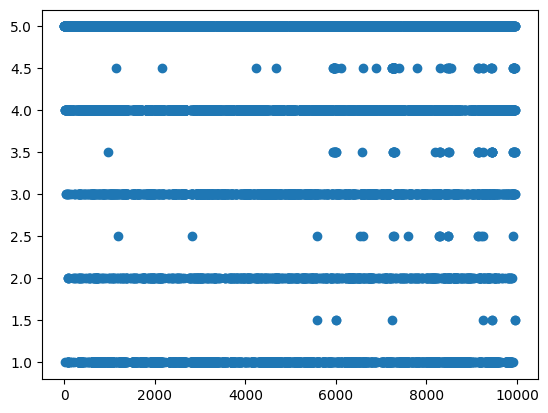

In [31]:
#Considering Rating as Categorical variable
plt.scatter(np.arange(len(data['Rating'])),data['Rating'])

In [32]:
print(data[data['Restaurant']=='Hotel Zara Hi-Fi']['Rating'].value_counts())


Rating
1.0    53
5.0    27
2.0    11
3.0     6
4.0     3
Name: count, dtype: int64


In [33]:
# Checking for data imbalance
from sklearn.utils import resample

data1=data[data['Restaurant']=='Hotel Zara Hi-Fi']
# Separate majority and minority classes
data_majority = data1[data1['Rating'] == 1.0]
data_minority_5 = data1[data1['Rating'] == 5.0]
data_minority_2 = data1[data1['Rating'] == 2.0]
data_minority_3 = data1[data1['Rating'] == 3.0]
data_minority_4 = data1[data1['Rating'] == 4.0]

data_minority_5_upsampled = resample(data_minority_5,replace=True,n_samples=len(data_majority),random_state=42)
data_minority_2_upsampled = resample(data_minority_2,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_3_upsampled = resample(data_minority_3,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_4_upsampled = resample(data_minority_4,replace=True,n_samples=len(data_majority), random_state=42)


data_balanced = pd.concat([data_majority,data_minority_5_upsampled,data_minority_2_upsampled,data_minority_3_upsampled,data_minority_4_upsampled])
#print(data_balanced)

print(data_balanced['Rating'].value_counts())


Rating
1.0    53
5.0    53
2.0    53
3.0    53
4.0    53
Name: count, dtype: int64


In [34]:
#Decision Tree Classifier

data1=data_balanced[['Reviewer','Pictures','Sentiment','Rating']].reset_index(drop=True)
#print(data1.head())

ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(sparse=False),['Reviewer'])],remainder='passthrough')
#data1[1] is names of reviewers
X=np.array(ct.fit_transform(data1[['Reviewer','Pictures','Sentiment']]))
y=data1.iloc[:,-1].values

lc=LabelEncoder()
lc.fit(y)
y_new=lc.transform(y)
print(lc.classes_)
X_train,X_test,y_train,y_test=train_test_split(X,y_new,test_size=0.2,random_state=42)
sc=StandardScaler()
X_train[:,-1:]=sc.fit_transform(X_train[:,-1:])
X_test[:,-1:]=sc.transform(X_test[:,-1:])

Dt=DecisionTreeClassifier(criterion='entropy')
Dt.fit(X_train,y_train)

y_pred=Dt.predict(X_test)
print(len(X_test[0]))

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))


[1. 2. 3. 4. 5.]
95
[[3. 3.]
 [2. 2.]
 [5. 5.]
 [1. 1.]
 [1. 1.]
 [2. 2.]
 [4. 4.]
 [1. 1.]
 [3. 3.]
 [2. 2.]
 [4. 4.]
 [3. 3.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [4. 4.]
 [3. 3.]
 [3. 3.]
 [2. 2.]
 [2. 2.]
 [5. 5.]
 [1. 1.]
 [1. 1.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [1. 1.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [4. 4.]
 [4. 4.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [5. 5.]]
[[12  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  9  0]
 [ 0  0  0  0 13]]
1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [35]:
# If Sharukh(Reviewer) visits a Hotel zafa hifi and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by decision tree
row=['Sharukh',6]
string='Good food but could have been better'
string=string.lower()
string=re.sub('[^a-zA-Z]',' ',string)
string=string.split()
ps=PorterStemmer()
string=[ps.stem(word) for word in string if word not in stop_words]
string=' '.join(string)
row.append(classifier.predict(cv.transform([string]))[0])
print(row)
row=pd.DataFrame([row])
row.columns=['Reviewer','Pictures','Sentiment']
print(lc.inverse_transform(Dt.predict(ct.transform(row))))

['Sharukh', 6, 1]
[2]


In [36]:
#Random Forest Classifier
rf=RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))


[[3. 3.]
 [2. 2.]
 [5. 5.]
 [1. 1.]
 [1. 1.]
 [2. 2.]
 [4. 4.]
 [1. 1.]
 [3. 3.]
 [2. 2.]
 [4. 4.]
 [3. 3.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [4. 4.]
 [3. 3.]
 [3. 3.]
 [2. 2.]
 [2. 2.]
 [5. 5.]
 [1. 1.]
 [1. 1.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [1. 1.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [4. 4.]
 [4. 4.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [5. 5.]]
[[12  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  9  0]
 [ 0  0  0  0 13]]
1.0


In [37]:
# If Sharukh(Reviewer) visits a Hotel zafa hifi and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by random forest tree
print(lc.inverse_transform(rf.predict(ct.transform(row))))

[3]


In [38]:
#KNN
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[3. 3.]
 [2. 2.]
 [5. 5.]
 [3. 1.]
 [1. 1.]
 [2. 2.]
 [4. 4.]
 [1. 1.]
 [3. 3.]
 [2. 2.]
 [4. 4.]
 [3. 3.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [4. 4.]
 [3. 3.]
 [3. 3.]
 [2. 2.]
 [2. 2.]
 [5. 5.]
 [1. 1.]
 [1. 1.]
 [3. 3.]
 [4. 4.]
 [5. 5.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [3. 3.]
 [1. 1.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [4. 4.]
 [4. 4.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [1. 1.]
 [2. 2.]
 [5. 5.]
 [5. 5.]
 [4. 4.]
 [1. 1.]
 [5. 5.]]
[[11  0  1  0  0]
 [ 0 11  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  9  0]
 [ 0  0  0  0 13]]
0.9811320754716981


In [39]:
# If Sharukh(Reviewer) visits a Hotel zafa hifi and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by KNN
print(lc.inverse_transform(knn.predict(ct.transform(row))))

[3]


Classification and prediction of ratings irrespective of the restaurant

In [40]:
data['Rating'].value_counts()

Rating
5.0    3832
4.0    2373
1.0    1735
3.0    1193
2.0     684
4.5      69
3.5      47
2.5      20
1.5       9
Name: count, dtype: int64

In [44]:

# Separate majority and minority classes
data_majority = data[data['Rating'] == 5.0]
data_minority_1 = data[data['Rating'] == 1.0]
data_minority_2 = data[data['Rating'] == 2.0]
data_minority_3 = data[data['Rating'] == 3.0]
data_minority_4 = data[data['Rating'] == 4.0]
data_minority_1_5 = data[data['Rating'] == 1.5]
data_minority_2_5 = data[data['Rating'] == 2.5]
data_minority_3_5 = data[data['Rating'] == 3.5]
data_minority_4_5 = data[data['Rating'] == 4.5]

data_minority_1_upsampled = resample(data_minority_1,replace=True,n_samples=len(data_majority),random_state=42)
data_minority_2_upsampled = resample(data_minority_2,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_3_upsampled = resample(data_minority_3,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_4_upsampled = resample(data_minority_4,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_1_5_upsampled = resample(data_minority_1_5,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_2_5_upsampled = resample(data_minority_2_5,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_3_5_upsampled = resample(data_minority_3_5,replace=True,n_samples=len(data_majority), random_state=42)
data_minority_4_5_upsampled = resample(data_minority_4_5,replace=True,n_samples=len(data_majority), random_state=42)

data_balanced = pd.concat([data_majority,data_minority_1_upsampled,data_minority_2_upsampled,data_minority_3_upsampled,data_minority_4_upsampled,data_minority_1_5_upsampled,data_minority_2_5_upsampled,data_minority_3_5_upsampled,data_minority_4_5_upsampled])
#print(data_balanced)

print(data_balanced['Rating'].value_counts())

Rating
5.0    3832
1.0    3832
2.0    3832
3.0    3832
4.0    3832
1.5    3832
2.5    3832
3.5    3832
4.5    3832
Name: count, dtype: int64


In [46]:
#DT

data1=data_balanced[['Reviewer','Pictures','Sentiment','Rating']].reset_index(drop=True)
#print(data1.head())

ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(sparse=False),['Reviewer'])],remainder='passthrough')
#data1[1] is names of reviewers
X=np.array(ct.fit_transform(data1[['Reviewer','Pictures','Sentiment']]))
y=data1.iloc[:,-1].values

lc=LabelEncoder()
lc.fit(y)
y_new=lc.transform(y)
print(lc.classes_)
X_train,X_test,y_train,y_test=train_test_split(X,y_new,test_size=0.2,random_state=42)
sc=StandardScaler()
X_train[:,-1:]=sc.fit_transform(X_train[:,-1:])
X_test[:,-1:]=sc.transform(X_test[:,-1:])

Dt=DecisionTreeClassifier(criterion='entropy')
Dt.fit(X_train,y_train)

y_pred=Dt.predict(X_test)
print(len(X_test[0]))

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
6991
[[3.5 3.5]
 [2.5 2.5]
 [1.5 1.5]
 ...
 [3.5 3.5]
 [2.  2. ]
 [2.  2. ]]
[[724   0  11   0  11   0   6   3  16]
 [  0 759   0   0   0   0   0   0   0]
 [ 22   1 733   0   4   1   3   0   2]
 [  0   0   0 763   0   0   0   0   0]
 [ 24   0  24   0 718   2  21   0  30]
 [  0   0   0   0   0 758   0   0   0]
 [ 14   0   5   0  56   3 516   4 121]
 [  0   0   0   0   0   0   0 779   0]
 [ 47   0   4   0  16   2  53   2 640]]
0.926355465352276


In [48]:
# If Sharukh(Reviewer) visits a hotel and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by decision tree
row=['Sharukh',6]
string='Good food but could have been better'
string=string.lower()
string=re.sub('[^a-zA-Z]',' ',string)
string=string.split()
ps=PorterStemmer()
string=[ps.stem(word) for word in string if word not in stop_words]
string=' '.join(string)
row.append(classifier.predict(cv.transform([string]))[0])
print(row)
row=pd.DataFrame([row])
row.columns=['Reviewer','Pictures','Sentiment']
print(lc.inverse_transform(Dt.predict(ct.transform(row))))

['Sharukh', 6, 1]
[4.]


In [49]:
#Random Forest Classifier
rf=RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))


[[3.5 3.5]
 [2.5 2.5]
 [1.5 1.5]
 ...
 [3.5 3.5]
 [2.  2. ]
 [2.  2. ]]
[[722   0  11   0  12   0   8   3  15]
 [  0 759   0   0   0   0   0   0   0]
 [ 27   1 718   0   8   1   8   0   3]
 [  0   0   0 763   0   0   0   0   0]
 [ 30   0  22   0 702   2  31   0  32]
 [  0   0   0   0   0 758   0   0   0]
 [ 20   0   5   0  53   4 511   4 122]
 [  0   0   0   0   0   0   0 779   0]
 [ 49   0   3   0  17   2 115   1 577]]
0.9117135401565671


In [50]:
# If Sharukh(Reviewer) visits a Hotel  and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by random forest tree
print(lc.inverse_transform(rf.predict(ct.transform(row))))

[4.]


In [51]:
#KNN
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[3.5 3.5]
 [2.5 2.5]
 [1.5 1.5]
 ...
 [3.5 3.5]
 [2.  2. ]
 [2.  2. ]]
[[635 103  12   0   6   2   9   3   1]
 [  0 759   0   0   0   0   0   0   0]
 [ 25  32 697   0   5   1   5   0   1]
 [  0   0   0 763   0   0   0   0   0]
 [ 20  62  28   1 633  19  39   3  14]
 [  0   0   0   0   0 758   0   0   0]
 [  7  77   8   6  72  44 478   5  22]
 [  0   0   0   0   0   0   0 779   0]
 [  7 544   4  16  23  26 100   2  42]]
0.8037112206436648


In [52]:
# If Sharukh(Reviewer) visits a Hotel and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by KNN
print(lc.inverse_transform(knn.predict(ct.transform(row))))

[3.5]


Classification and prediction of ratings irrespective of restaurant and reviewer i.e only based on the no of pictures and the sentiment of the review

In [53]:
#DT

data1=data_balanced[['Pictures','Sentiment','Rating']].reset_index(drop=True)
#print(data1.head())


X=np.array(data1[['Pictures','Sentiment']])
y=data1.iloc[:,-1].values

lc=LabelEncoder()
lc.fit(y)
y_new=lc.transform(y)
print(lc.classes_)
X_train,X_test,y_train,y_test=train_test_split(X,y_new,test_size=0.2,random_state=42)
sc=StandardScaler()
X_train[:,-1:]=sc.fit_transform(X_train[:,-1:])
X_test[:,-1:]=sc.transform(X_test[:,-1:])

Dt=DecisionTreeClassifier(criterion='entropy')
Dt.fit(X_train,y_train)

y_pred=Dt.predict(X_test)
print(len(X_test[0]))

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))


[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
2
[[3.5 3.5]
 [4.  2.5]
 [1.  1.5]
 ...
 [3.5 3.5]
 [1.  2. ]
 [1.  2. ]]
[[654   1  30   0   0  10   3   1  72]
 [415  88   0   0   0   0   0   0 256]
 [532   2  53  14   1  27   9   0 128]
 [377   0   0 127   0   0  46   0 213]
 [257  10  30  32   8  47  68   9 358]
 [ 46   0   0  54   0 244  79   0 335]
 [ 54   5  11  28   1  42 126  22 430]
 [ 97  19   0  38   0  30  77  51 467]
 [ 47   0   1  21   0  13  74   9 599]]
0.28269063496665703


In [55]:
# If a Reviewer visits a hotel and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by decision tree
row=[6]
string='Good food but could have been better'
string=string.lower()
string=re.sub('[^a-zA-Z]',' ',string)
string=string.split()
ps=PorterStemmer()
string=[ps.stem(word) for word in string if word not in stop_words]
string=' '.join(string)
row.append(classifier.predict(cv.transform([string]))[0])
row=pd.DataFrame([row])
row.columns=['Pictures','Sentiment']
print(lc.inverse_transform(Dt.predict(row)))

[3.5]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [56]:
#Random Forest Classifier
rf=RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[3.5 3.5]
 [4.  2.5]
 [1.  1.5]
 ...
 [3.5 3.5]
 [1.  2. ]
 [1.  2. ]]
[[654   1  30   0   0  10   3   1  72]
 [415  88   0   0   0   0   0   0 256]
 [532   2  53  14   1  27   9   0 128]
 [377   0   0 127   0   0  46   0 213]
 [257  10  30  32   8  47  68   9 358]
 [ 46   0   0  54   0 244  79   0 335]
 [ 54   5  11  28   1  42 126  22 430]
 [ 97  19   0  38   0  30  77  51 467]
 [ 47   0   1  21   0  13  74   9 599]]
0.28269063496665703


In [57]:
# If a Reviewer visits a hotel and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by random forest classifier
print(lc.inverse_transform(rf.predict(row)))

[3.5]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [58]:
#KNN
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(np.concatenate((lc.inverse_transform(y_pred).reshape(len(y_pred),1),lc.inverse_transform(y_test).reshape(len(y_test),1)),axis=1))

cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

[[1.  3.5]
 [4.  2.5]
 [2.5 1.5]
 ...
 [3.5 3.5]
 [2.5 2. ]
 [2.5 2. ]]
[[ 37   1   0 654   0   3  75   1   0]
 [  0  88   0 415   0   0 256   0   0]
 [ 67   2   3 546   1  10 136   0   1]
 [  0   0   0 504   0   0 259   0   0]
 [ 38  10   1 289  11  27 432  11   0]
 [ 29   0   0 100   0 168 412  49   0]
 [ 13   5   2  82  11  37 536  31   2]
 [  0  19   0 135   0  27 532  66   0]
 [  1   0   0  68   5  20 658  11   1]]
0.20498695273992462


In [59]:
# If a Reviewer visits a hotel and gives a review as 'Good food but could have been better' and uploads 6 pictures the rating he probably gives by KNN classifier
print(lc.inverse_transform(knn.predict(row)))

[3.5]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
